In [8]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from src.helper_functions import train_step, test_step, accuracy_fn, run_model, print_train_time
from src.few_shot_learning import set_seed, calculate_accuracy, load_cinic10, plot_confusion_matrix
from src.plots_functions import multiple_runs_with_uncertainty_band
from timeit import default_timer as timer
set_seed(213)

In [2]:
class FewShotConvNeXt(nn.Module):
    def __init__(self, num_classes=10):
        super(FewShotConvNeXt, self).__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=True)  # Load pretrained ConvNeXt-Tiny
        self.backbone.head.fc = nn.Linear(self.backbone.head.fc.in_features, num_classes)  # Modify last layer

    def forward(self, x):
        return self.backbone(x)

In [22]:
def train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=10, lr=0.001, optimizer='adam', scheduling=False, silent=False):
    
    time_start = timer()
    metrics = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    # Freeze all layers
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Unfreeze the final classification layer (head.fc)
    for param in model.backbone.head.fc.parameters():
        param.requires_grad = True

    # Unfreeze specific stages (e.g., last two stages)
    for param in model.backbone.stages[2].parameters():  # Unfreeze Stage 3
        param.requires_grad = True
    for param in model.backbone.stages[3].parameters():  # Unfreeze Stage 4
        param.requires_grad = True    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if scheduling:
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        if scheduling:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(
            data_loader=train_dataloader,
            model=model,
            loss_fn=criterion,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
            silent=silent,
        )
        if scheduling:
            scheduler.step()  # Update LR
        test_loss, test_acc = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_fn=criterion,
            accuracy_fn=accuracy_fn,
            device=device,
            silent=silent,
        )

        # Append the metrics to the respective lists
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)

    time_end = timer()
    total_time = print_train_time(
        start=time_start, end=time_end, device=device, silent=silent
    )
    return metrics, total_time

In [23]:
data_dir = "../../data"
train_dataloader = load_cinic10(data_dir, few_shot_per_class=100)
test_dataloader = load_cinic10(data_dir, few_shot_per_class=100, split="test")

In [24]:
metrics_list = []
for _ in range(5):
    model = FewShotConvNeXt()
    metrics, time = train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=20, lr=0.001,
                                                optimizer='adam', scheduling=False)
    metrics_list.append(metrics)

Train loss: 2.69273 | Train accuracy: 12.70%
Test loss: 2.50569 | Test accuracy: 19.35%

Train loss: 2.07805 | Train accuracy: 20.24%
Test loss: 2.23855 | Test accuracy: 17.96%

Train loss: 1.94913 | Train accuracy: 21.03%
Test loss: 2.02177 | Test accuracy: 20.93%

Train loss: 1.74149 | Train accuracy: 27.38%
Test loss: 1.80973 | Test accuracy: 31.85%

Train loss: 1.61975 | Train accuracy: 31.85%
Test loss: 1.71855 | Test accuracy: 31.94%

Train loss: 1.42044 | Train accuracy: 38.99%
Test loss: 1.74054 | Test accuracy: 37.00%

Train loss: 1.27475 | Train accuracy: 48.51%
Test loss: 1.66935 | Test accuracy: 40.87%

Train loss: 1.04458 | Train accuracy: 56.55%
Test loss: 1.62558 | Test accuracy: 41.87%

Train loss: 0.87317 | Train accuracy: 63.69%
Test loss: 2.31617 | Test accuracy: 39.98%

Train loss: 0.87156 | Train accuracy: 63.59%
Test loss: 1.65882 | Test accuracy: 45.04%

Train loss: 0.66195 | Train accuracy: 74.21%
Test loss: 1.87208 | Test accuracy: 44.94%

Train loss: 0.50349 |

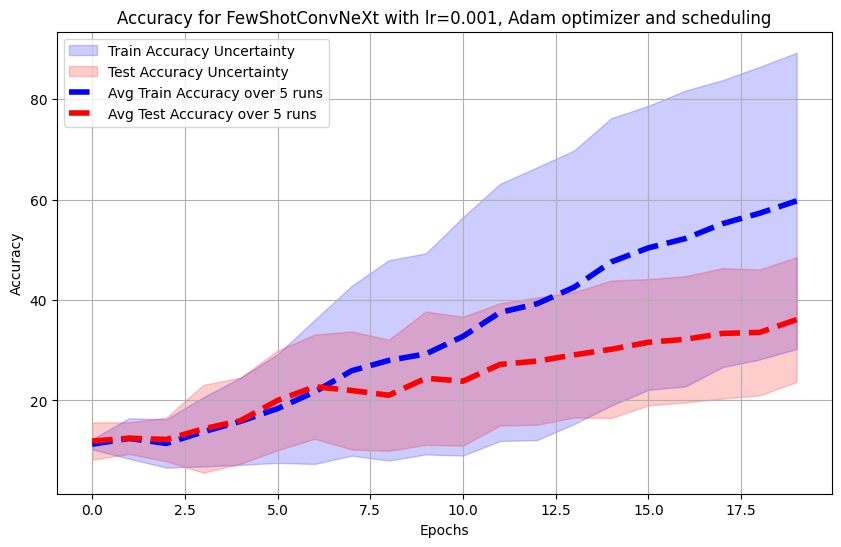

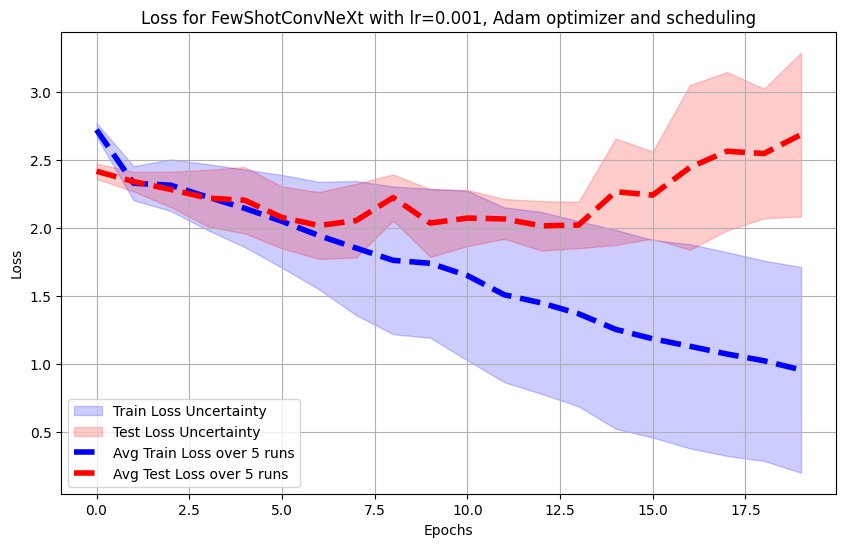

In [25]:
experiment_name = "FewShotConvNeXt with lr=0.001, Adam optimizer and scheduling"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [26]:
metrics_list = []
for _ in range(5):
    model = FewShotConvNeXt()
    metrics, time = train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=20, lr=0.0001,
                                                optimizer='adam', scheduling=False)
    metrics_list.append(metrics)

Train loss: 1.71699 | Train accuracy: 43.15%
Test loss: 1.17501 | Test accuracy: 57.74%

Train loss: 0.72630 | Train accuracy: 74.31%
Test loss: 1.48769 | Test accuracy: 52.58%

Train loss: 0.33657 | Train accuracy: 89.38%
Test loss: 1.55563 | Test accuracy: 55.26%

Train loss: 0.13706 | Train accuracy: 95.63%
Test loss: 1.73580 | Test accuracy: 56.15%

Train loss: 0.05539 | Train accuracy: 98.51%
Test loss: 1.68962 | Test accuracy: 58.93%

Train loss: 0.04577 | Train accuracy: 98.61%
Test loss: 1.76730 | Test accuracy: 58.43%

Train loss: 0.03357 | Train accuracy: 99.21%
Test loss: 1.77881 | Test accuracy: 57.54%

Train loss: 0.04060 | Train accuracy: 98.61%
Test loss: 1.85676 | Test accuracy: 58.83%

Train loss: 0.03107 | Train accuracy: 99.31%
Test loss: 1.79898 | Test accuracy: 58.13%

Train loss: 0.06053 | Train accuracy: 98.81%
Test loss: 2.00517 | Test accuracy: 56.94%

Train loss: 0.03879 | Train accuracy: 99.21%
Test loss: 2.00619 | Test accuracy: 57.64%

Train loss: 0.02536 |

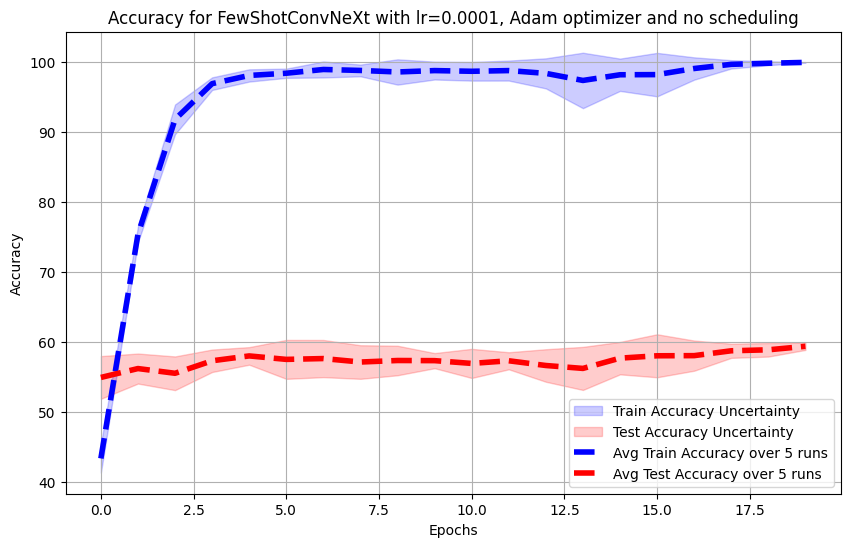

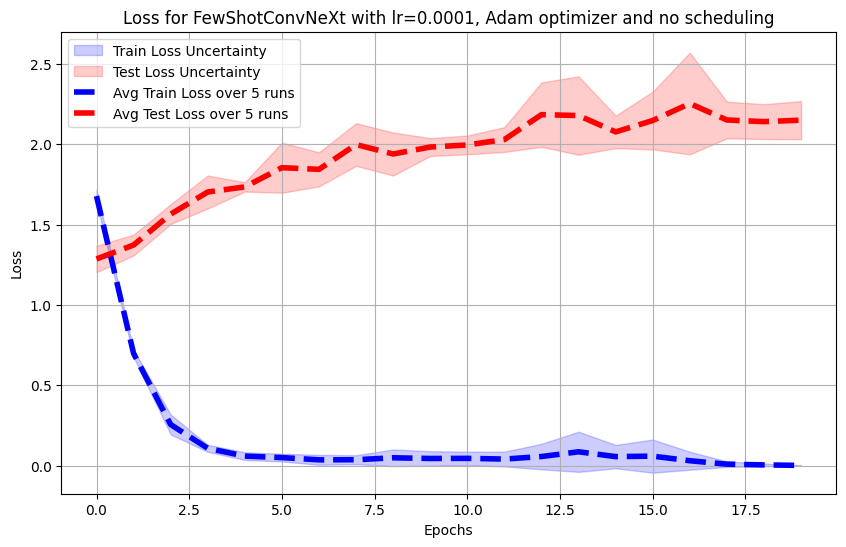

In [28]:
experiment_name = "FewShotConvNeXt with lr=0.0001, Adam optimizer and no scheduling"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [29]:
metrics_list = []
for _ in range(5):
    model = FewShotConvNeXt()
    metrics, time = train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=20, lr=0.00001,
                                                optimizer='adam', scheduling=False)
    metrics_list.append(metrics)

Train loss: 2.15858 | Train accuracy: 25.40%
Test loss: 1.76109 | Test accuracy: 39.19%

Train loss: 1.16663 | Train accuracy: 60.32%
Test loss: 1.47704 | Test accuracy: 49.40%

Train loss: 0.72297 | Train accuracy: 80.06%
Test loss: 1.40017 | Test accuracy: 52.38%

Train loss: 0.41231 | Train accuracy: 91.17%
Test loss: 1.37070 | Test accuracy: 54.27%

Train loss: 0.23466 | Train accuracy: 96.33%
Test loss: 1.36188 | Test accuracy: 53.27%

Train loss: 0.13021 | Train accuracy: 98.81%
Test loss: 1.37059 | Test accuracy: 55.16%

Train loss: 0.07634 | Train accuracy: 99.60%
Test loss: 1.38430 | Test accuracy: 55.85%

Train loss: 0.05099 | Train accuracy: 100.00%
Test loss: 1.41657 | Test accuracy: 56.35%

Train loss: 0.03505 | Train accuracy: 100.00%
Test loss: 1.41150 | Test accuracy: 55.95%

Train loss: 0.02623 | Train accuracy: 100.00%
Test loss: 1.45094 | Test accuracy: 55.85%

Train loss: 0.02044 | Train accuracy: 100.00%
Test loss: 1.47678 | Test accuracy: 55.85%

Train loss: 0.016

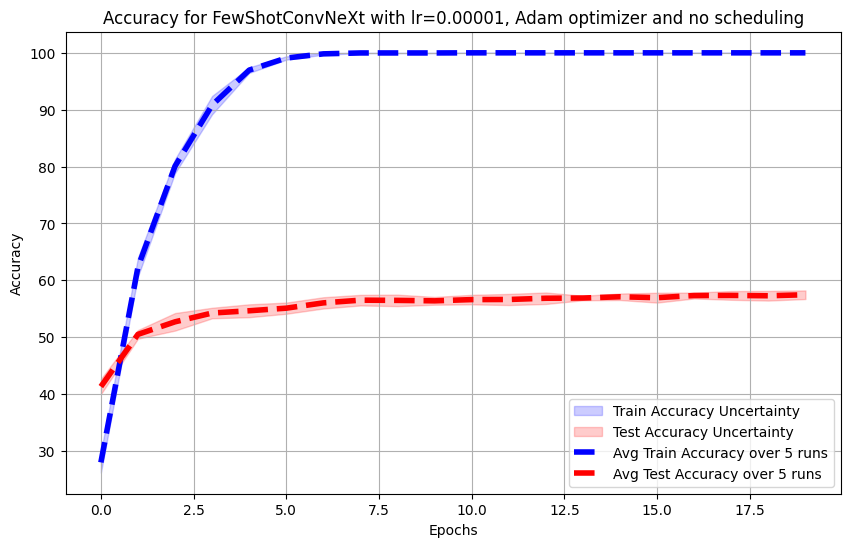

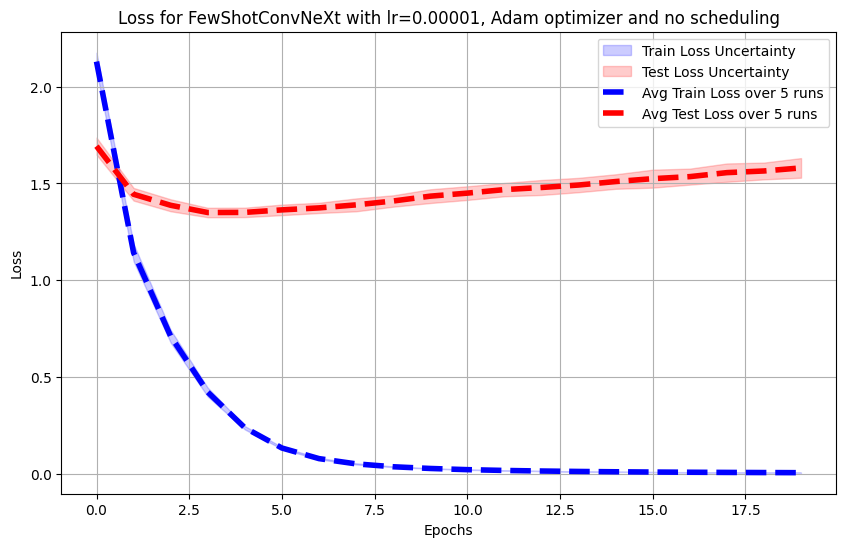

In [30]:
experiment_name = "FewShotConvNeXt with lr=0.00001, Adam optimizer and no scheduling"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [31]:
metrics_list = []
for _ in range(5):
    model = FewShotConvNeXt()
    metrics, time = train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=20, lr=0.0001,
                                                optimizer='adam', scheduling=True)
    metrics_list.append(metrics)

Train loss: 1.68107 | Train accuracy: 44.54%
Test loss: 1.22378 | Test accuracy: 57.54%

Train loss: 0.79059 | Train accuracy: 72.52%
Test loss: 1.37942 | Test accuracy: 57.54%

Train loss: 0.28414 | Train accuracy: 90.38%
Test loss: 1.49073 | Test accuracy: 56.25%

Train loss: 0.12164 | Train accuracy: 95.83%
Test loss: 1.66533 | Test accuracy: 57.64%

Train loss: 0.05261 | Train accuracy: 98.61%
Test loss: 1.84610 | Test accuracy: 56.45%

Train loss: 0.02525 | Train accuracy: 99.21%
Test loss: 1.70463 | Test accuracy: 60.42%

Train loss: 0.00319 | Train accuracy: 100.00%
Test loss: 1.66231 | Test accuracy: 62.20%

Train loss: 0.00159 | Train accuracy: 100.00%
Test loss: 1.67940 | Test accuracy: 62.60%

Train loss: 0.00123 | Train accuracy: 100.00%
Test loss: 1.69290 | Test accuracy: 62.70%

Train loss: 0.00103 | Train accuracy: 100.00%
Test loss: 1.73549 | Test accuracy: 61.90%

Train loss: 0.00090 | Train accuracy: 100.00%
Test loss: 1.73068 | Test accuracy: 62.20%

Train loss: 0.00

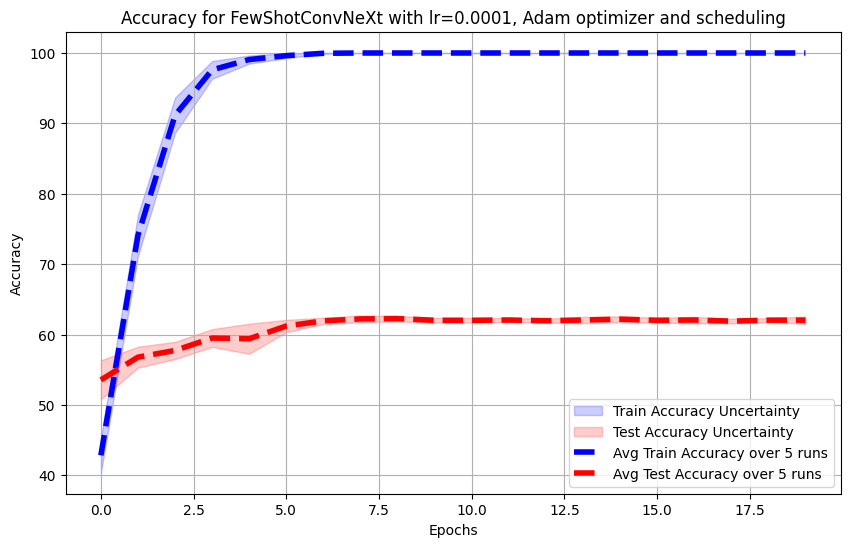

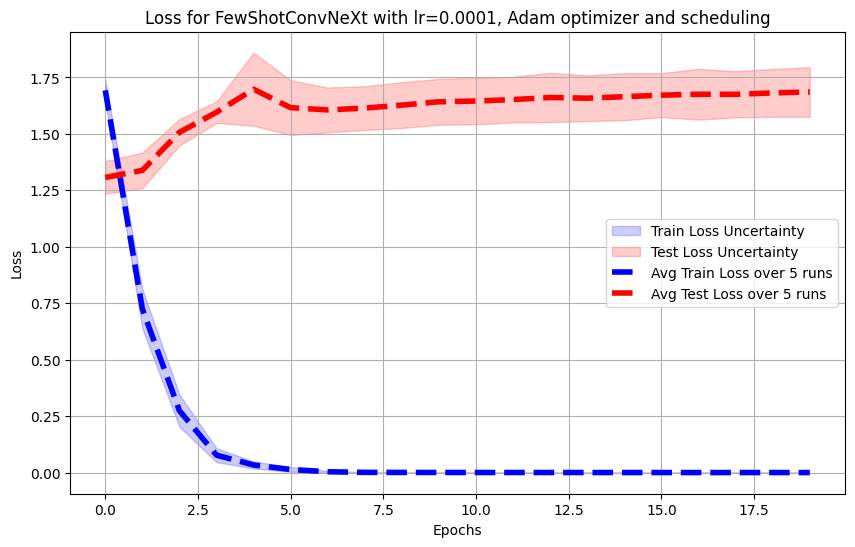

In [32]:
experiment_name = "FewShotConvNeXt with lr=0.0001, Adam optimizer and scheduling"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [33]:
metrics_list = []
for _ in range(5):
    model = FewShotConvNeXt()
    metrics, time = train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=15, lr=0.0001, optimizer='sgd', scheduling=False)
    metrics_list.append(metrics)

Train loss: 2.11178 | Train accuracy: 27.08%
Test loss: 1.61674 | Test accuracy: 42.36%

Train loss: 1.14094 | Train accuracy: 61.31%
Test loss: 1.35571 | Test accuracy: 52.18%

Train loss: 0.77556 | Train accuracy: 74.90%
Test loss: 1.29227 | Test accuracy: 54.07%

Train loss: 0.53170 | Train accuracy: 84.62%
Test loss: 1.31935 | Test accuracy: 53.87%

Train loss: 0.36476 | Train accuracy: 90.77%
Test loss: 1.34199 | Test accuracy: 55.46%

Train loss: 0.24494 | Train accuracy: 95.24%
Test loss: 1.35278 | Test accuracy: 56.05%

Train loss: 0.15972 | Train accuracy: 98.12%
Test loss: 1.36492 | Test accuracy: 56.55%

Train loss: 0.10735 | Train accuracy: 99.11%
Test loss: 1.38086 | Test accuracy: 57.24%

Train loss: 0.07667 | Train accuracy: 99.70%
Test loss: 1.42484 | Test accuracy: 56.65%

Train loss: 0.05559 | Train accuracy: 99.80%
Test loss: 1.44743 | Test accuracy: 56.75%

Train loss: 0.04351 | Train accuracy: 99.90%
Test loss: 1.48539 | Test accuracy: 57.04%

Train loss: 0.03537 |

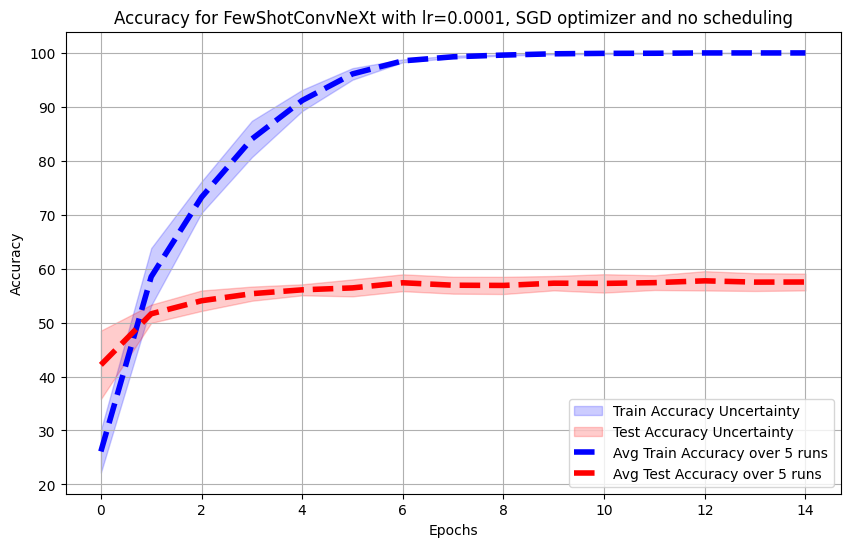

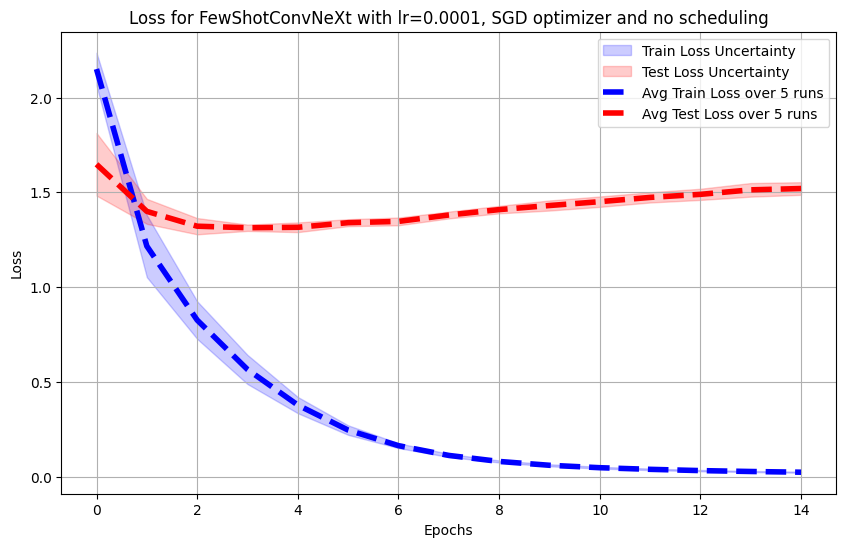

In [34]:
experiment_name = "FewShotConvNeXt with lr=0.0001, SGD optimizer and no scheduling"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [35]:
metrics_list = []
for _ in range(5):
    model = FewShotConvNeXt()
    metrics, time = train_few_shot_convnext(model, train_dataloader, test_dataloader, epochs=15, lr=0.0001, optimizer='sgd', scheduling=True)
    metrics_list.append(metrics)

Train loss: 2.00715 | Train accuracy: 30.56%
Test loss: 1.52780 | Test accuracy: 45.24%

Train loss: 1.09752 | Train accuracy: 62.30%
Test loss: 1.31607 | Test accuracy: 52.58%

Train loss: 0.74326 | Train accuracy: 77.78%
Test loss: 1.24831 | Test accuracy: 55.65%

Train loss: 0.50977 | Train accuracy: 85.81%
Test loss: 1.21489 | Test accuracy: 55.65%

Train loss: 0.36298 | Train accuracy: 92.46%
Test loss: 1.20951 | Test accuracy: 56.55%

Train loss: 0.27434 | Train accuracy: 96.03%
Test loss: 1.20786 | Test accuracy: 57.64%

Train loss: 0.22304 | Train accuracy: 97.32%
Test loss: 1.20712 | Test accuracy: 57.64%

Train loss: 0.19443 | Train accuracy: 98.12%
Test loss: 1.20864 | Test accuracy: 57.84%

Train loss: 0.18024 | Train accuracy: 98.41%
Test loss: 1.20811 | Test accuracy: 57.84%

Train loss: 0.17474 | Train accuracy: 98.71%
Test loss: 1.22058 | Test accuracy: 57.44%

Train loss: 0.17153 | Train accuracy: 98.81%
Test loss: 1.21227 | Test accuracy: 57.84%

Train loss: 0.17216 |

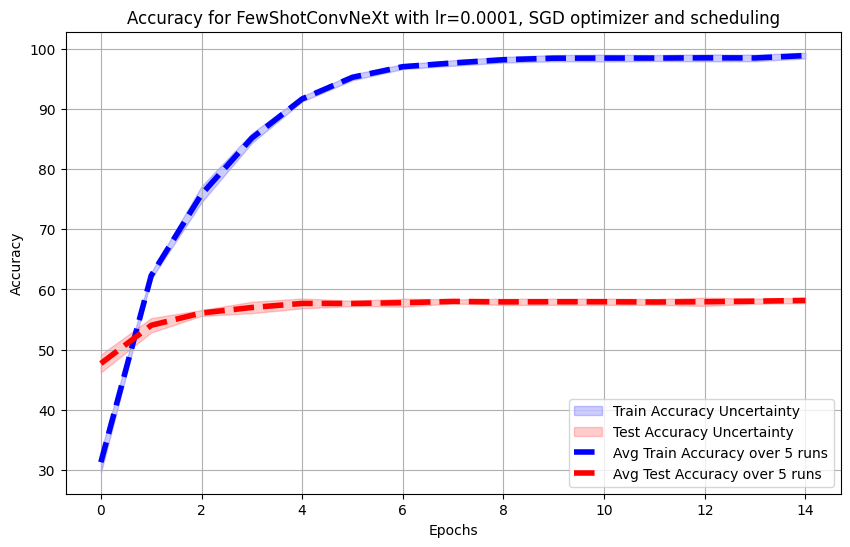

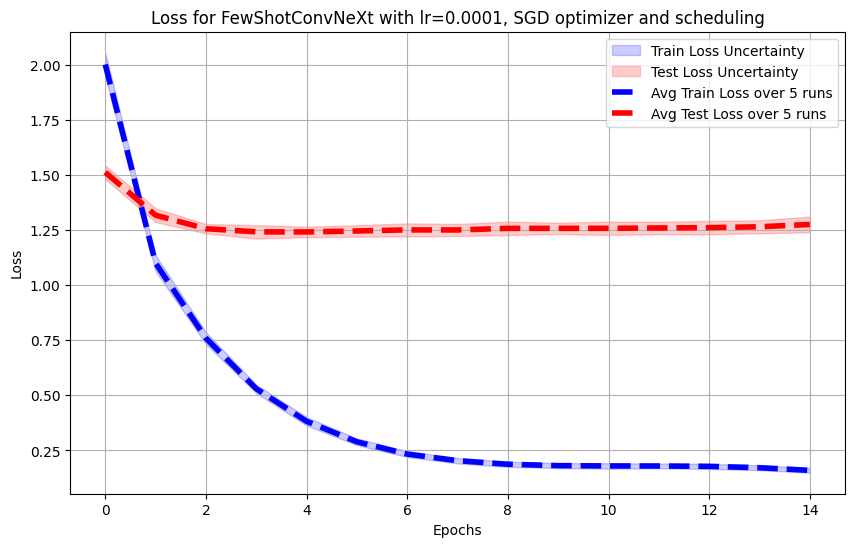

In [36]:
experiment_name = "FewShotConvNeXt with lr=0.0001, SGD optimizer and scheduling"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")